In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('./bursa.mplstyle')

from tb_colormaps import *

donors = [f'TBd{k}' for k in range(1,7)]

######################## PATH CONFIG ################################
FIGURE_OUTDIR = '../../analysis/figures/ed figures'
full_df_loc =  '../../data/vdj/integrated_cell_calls_ambient_annotated.tsv.gz'
sample_relationships_loc = '../../snakemake_workflow/samplesheets/sample_relationships.tsv'
######################## ############ ################################



In [2]:

tissue_indices = {'P':0,
                  'B':1,
                  'L':2,
                  'S':3
                 }
tissue_list = ['PB','BM', 'LN', 'SP']

df = pd.read_table(full_df_loc, usecols = ['cb','sample_uid',
                                            'sample_uid_gex',
                                            'sample_uid_vdj',
                                            'contaminant_status',
                                            'locus',
                                            'vdj_sequence',
                                            'n_umis',
                                            'v_pident',
                                            'tissue',
                                            'donor',
                                            'c_call',
                                            'multiplet_status',
                                            'probable_hq_single_b_cell',
                                            'is_ambient_source',
                                            'vdj_is_from_ambient',
                                            'Immune_All_Low_predicted_labels'], 
                    nrows=None, 
                    low_memory=False)
df['is_gex_sample'] = df.sample_uid_gex.notna()

celltypist_simpler = {
    "Proliferative germinal center B cells": "GC B cells",
    "Germinal center B cells": "GC B cells", 
    "Age-associated B cells" : "ABCs", 
    "Plasma cells":"ASCs",
    "Plasmablasts":"ASCs"
}

df["celltype"] = df.Immune_All_Low_predicted_labels.map(lambda x: celltypist_simpler.get(x, x))
df_clean = df[(df.probable_hq_single_b_cell) & (df.multiplet_status == 1)& (~(df.vdj_is_from_ambient.astype(bool)))]
naive =  df_clean.celltype == 'Naive B cells'
unswitched = df_clean.c_call.isin(['IGHM','IGHD'])
permitted = (naive & unswitched) | ~(naive.astype(bool))
df_clean = df_clean[permitted]
df_clean = df_clean[~df_clean.celltype.str.startswith('Plasma')]

In [3]:
df['donor_tissue'] = df['donor'] + "_" + df['tissue']
donor_tissue_availability = df.groupby('donor')['donor_tissue'].unique()

print(df_clean.celltype.value_counts())
abundant_categories = df_clean.celltype.value_counts() > 99
abundant_categories = abundant_categories[abundant_categories==True].index
data = df_clean[df_clean.celltype.isin(abundant_categories)]
data = (
    data.groupby(["donor", "tissue"])
    .celltype.value_counts(normalize=True)
    .rename("fraction")
    .reset_index()
)

Naive B cells           91421
Memory B cells          72488
ASCs                    17567
ABCs                     3131
GC B cells                102
Pre-pro-B cells             5
Cycling B cells             3
Transitional B cells        3
B cells                     1
Name: celltype, dtype: int64


In [4]:
sample_relationships=pd.read_table(sample_relationships_loc).set_index('sample_uid')
sample_relationships['encapsulation_sibling_sample'] = sample_relationships['encapsulation_sibling_sample'].fillna('')
sample_relationships['emulsion'] = sample_relationships.apply(lambda x: ";".join(sorted([x['sample_uid_vdj'],
                                                                                x['encapsulation_sibling_sample']])),
                                                                                axis=1)

/var/folders/dz/swf8xvz50dv721hmb0b_nps00000gn/T/ipykernel_11885/648314987.py:125: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax[0].get_shared_y_axes().join(ax[0], ax[1])


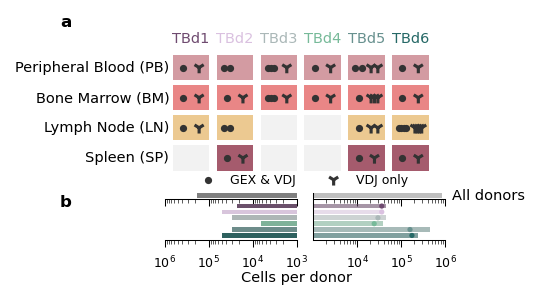

In [5]:
cell_counts_xpos = 0.1
cell_counts_ypos = -0.28
cell_counts_height = 0.25
cell_counts_ypos_lower=0.05
cell_counts_ypad = 0.2
cell_counts_xpad = 0.05
cell_counts_width=0.4
totals_height_fraction = 6
donor_id_xpos = 0

fig, ax = plt.subplots(4,6,figsize=(2.2,1.))

tissue_labels = {'PB': 'Peripheral Blood (PB)',
                 'BM': 'Bone Marrow (BM)',
                 'LN': 'Lymph Node (LN)',
                 'SP': 'Spleen (SP)'}
plt.text(-0.2, 1.1, 'a', horizontalalignment='center',
     fontsize=8, 
     weight='bold',
     verticalalignment='center', transform=fig.transFigure)

plt.text(-0.2, -0.1, 'b', horizontalalignment='center',
     fontsize=8, 
     weight='bold',
     verticalalignment='center', transform=fig.transFigure)

for d_it, donor in enumerate(donors):
    donor_tissue_list = [t for t in tissue_list if f'{donor}_{t}' in donor_tissue_availability[donor]]
    for it, tissue in enumerate(tissue_list):
        if tissue in donor_tissue_list:
            r,g,b,a = mpl.colors.to_rgba(tissue_colors[tissue])
            for spine in ['bottom', 'left', 'top', 'right']:
                ax[it,d_it].axes.spines[spine].set_visible(False)
            bg_color = (r,g,b,0.7)
            ax[it,d_it].set_facecolor(bg_color)
            emulsions = sample_relationships[sample_relationships.donor_tissue == 
                                                    f'{donor}_{tissue}']
            emulsions = emulsions.groupby(['emulsion','is_gex_sample']).size().reset_index().sort_values('is_gex_sample',
                                                                                                           ascending=False)            # -1 -> 0 white
            # 0->1 gex
            # 1->1.5 white
            # 1.5->2 white
            # 2->3 overload
            # 3->4 white
            filled_center = 0.5
            unfilled_center = 2.5
            circle_color='0.2'
            ax[it,d_it].set_xlim([-0.8, 3.8])
            filled = emulsions.is_gex_sample.values
            if filled.sum() > 0:
                n_filled = filled.sum()
                xs_filled = np.linspace(0,0.85, n_filled) 
                xs_filled = xs_filled - xs_filled.mean() + filled_center
                # print(xs_filled,np.ones(n_filled))
                
                ax[it,d_it].scatter(xs_filled, np.ones(n_filled), 
                                    marker='o', 
                                    ec=circle_color, 
                                    fc=circle_color,
                                    s=12,
                                   lw=0)
                # ax[it,d_it].scatter(xs_filled, np.ones(n_filled), 
                #                     marker='1', 
                #                     ec=circle_color, 
                #                     s=32,
                #                     fc="none",
                #                    lw=1.5)
            if filled.sum() < emulsions.shape[0]:
                xs_unfilled = np.linspace(0,0.85,(~filled.astype(bool)).sum())
                xs_unfilled = xs_unfilled - xs_unfilled.mean() + unfilled_center
                # print(xs_unfilled)
                ax[it,d_it].scatter(xs_unfilled, np.ones((~filled.astype(bool)).sum()), 
                                    marker='1', 
                                    ec=circle_color, 
                                    s=30,
                                    fc="none",
                                   lw=1.5)

        else:
            ax[it,d_it].set_facecolor((0,0,0,0.05))
            for spine in ['bottom', 'left', 'top', 'right']:
                ax[it,d_it].axes.spines[spine].set_visible(False)

        ax[it,d_it].axes.get_xaxis().set_visible(False)
        ax[it,d_it].axes.get_yaxis().set_visible(False)
        
        
    ax[0, d_it].set_title(donor, color=donor_colors[donor], weight='regular')
for it, tissue in enumerate(tissue_list):
    ax[it,0].text(-0.1, 0.5, tissue_labels[tissue], color='k', va='center', ha='right',  weight='regular',
                        transform=ax[it,0].transAxes, fontsize=7)
circle_color = '0.2'
ax[0,-1].scatter([], [], marker='o', 
                        ec=circle_color, 
                        s=12,
                        fc= circle_color,
                        lw=0,
                        label='GEX & VDJ')

ax[0,-1].scatter([], [], marker='1', 
                        ec=circle_color, 
                        s=30,
                        fc="none",
                        lw=1.5,
                        label='VDJ only')
ax[0,-1].legend(loc='lower right', frameon=False, bbox_to_anchor=(.75,-4.67), ncol=2)


ax_totals = [fig.add_axes([cell_counts_xpos,
                                 cell_counts_ypos + cell_counts_ypad,
                                 cell_counts_width,
                                 abs(cell_counts_height/totals_height_fraction)]),
             fig.add_axes([cell_counts_xpos+cell_counts_width+cell_counts_xpad,
                                 cell_counts_ypos + cell_counts_ypad, 
                                 cell_counts_width,
                                 abs(cell_counts_height)/totals_height_fraction])]
ax = [fig.add_axes([cell_counts_xpos,
                           -0.35,
                           cell_counts_width,
                           abs(cell_counts_height)]), 
             fig.add_axes([cell_counts_xpos+cell_counts_width+cell_counts_xpad,
                           -0.35,
                           cell_counts_width,
                           abs(cell_counts_height)])]
ax[0].get_shared_y_axes().join(ax[0], ax[1])

bcellcounts = df_clean.groupby(['donor','is_gex_sample']).size().reset_index()
cellcounts = df.groupby(['donor','is_gex_sample']).size().reset_index()
unique_vdjs = df.groupby(['donor','is_gex_sample'])['vdj_sequence'].nunique().reset_index()

g=sns.barplot(bcellcounts[bcellcounts.is_gex_sample==True],
           x=0,
           y='donor',
           palette=donor_colors, 
           ax=ax[0])

g=sns.barplot(cellcounts[cellcounts.is_gex_sample==False],
           x=0,
           y='donor',
           palette=donor_colors, 
           ax=ax[1], 
           alpha=0.6)

g=sns.scatterplot(unique_vdjs[unique_vdjs.is_gex_sample==False],
           x='vdj_sequence',
           y='donor',
           hue='donor',
           marker='.',
           linewidth=0,
           palette=donor_colors, 
           ax=ax[1], 
           alpha=1., 
           legend=False)

ax_totals[0].set_xlabel('')
ax_totals[1].set_xlabel('')
ax[0].set_xlabel('', fontsize=7)
ax[1].set_xlabel('', fontsize=7)
ax[0].text(1,-1, 'Cells per donor', fontsize=7, transform=ax[0].transAxes, va='center', ha='center')


ax[1].set_ylabel('')
ax_totals[1].set_ylabel('')

ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=90)
ax[1].set_yticklabels([])
ax[0].set_ylabel('', fontsize=7)
# ax_totals[1].set_ylabel('Total',fontsize=7, rotation=90)

ax[0].set_xlim([10**6,10**3])
ax[1].set_xlim([10**3,10**6])
ax_totals[0].set_xlim([10**6,10**3])
ax_totals[1].set_xlim([10**3,10**6])

bcell_totals=df_clean.groupby('is_gex_sample').size().reset_index()

totals=df.groupby('is_gex_sample').size().reset_index()

g=sns.barplot(bcell_totals[bcell_totals.is_gex_sample==True],
           x=0,
           ax=ax_totals[0],
           color='0.5')
g=sns.barplot(totals[totals.is_gex_sample==False],
           x=0,
           ax=ax_totals[1], 
           alpha=0.5,
           color='0.5')

sns.despine(ax=ax[0], left=True, top=True)
sns.despine(ax=ax[1], right=True, top=True)
sns.despine(ax=ax_totals[0], left=True, top=True, bottom=False)
sns.despine(ax=ax_totals[1], right=True, top=True, bottom=False)

for i in [0,1]:
    ax[i].set_xscale('log')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
    ax_totals[i].set_xscale('log')
    ax_totals[i].set_xlabel('')

    ax_totals[i].set_ylim([-0.5,0.5])
    ax_totals[i].set_yticks([])

    # ax_totals[i].set_xticks([])
    # ax_totals[i].set_xticks([], minor=True)
    ax_totals[i].set_xticklabels([])
ax[0].set_xticks([10**3, 10**4, 10**5, 10**6])
ax[1].set_xticks([10**4, 10**5, 10**6])
ax[1].set_xlim([10**3, 10**6])

ax_totals[1].yaxis.label.set(rotation='horizontal', ha='right');
ax_totals[1].text(1.05, 0.5, 'All donors', va='center', fontsize=7, transform=ax_totals[1].transAxes)
# fig.tight_layout(h_pad=-0.9, pad=10)

fig.savefig('../figures/paper figures/overview_figure_raw.pdf', bbox_inches='tight')


,donor,tissue,celltype,fraction,celltypist_rank
0,TBd1,BM,Naive B cells,0.650654,0.000000
1,TBd1,BM,ASCs,0.297051,2.000000
2,TBd1,BM,Memory B cells,0.048951,1.000000
3,TBd1,BM,ABCs,0.003040,3.000000
4,TBd1,BM,GC B cells,0.000304,4.000000
...,...,...,...,...,...
6,TBd4,PB,GC B cells,0.000032,4.084810
7,TBd5,BM,GC B cells,0.000032,3.972849
8,TBd5,PB,GC B cells,0.000032,4.025406
9,TBd5,LN,GC B cells,0.000032,3.950142


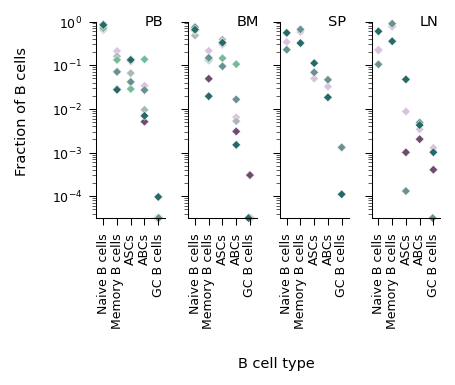

In [18]:

fig, celltypeax = plt.subplots(1,4,figsize=(3,2.5), sharey=True)
celltypeax = celltypeax.flatten()

tissue_labels = {'PB': 'Peripheral Blood (PB)',
                 'BM': 'Bone Marrow (BM)',
                 'LN': 'Lymph Node (LN)',
                 'SP': 'Spleen (SP)'}
EPS = 10**-4.5

tissue_list = ['PB','BM','SP','LN']

celltypist_rank = data.groupby('celltype')['fraction'].mean().sort_values(ascending=False).reset_index().reset_index()
celltypist_rank = celltypist_rank.set_index('celltype')['index']

data['celltypist_rank'] = data['celltype'].map(celltypist_rank)

# fill in zeros
null_rows = []

for donor in donors:
    for donor_tissue in donor_tissue_availability[donor]:
        tissue = donor_tissue.split("_")[-1]
        for celltype in celltypist_rank.index.values:
            if len(data[(data.donor==donor) & (data.tissue==tissue) & (data.celltype==celltype)]) > 0:
                pass
            else:
                new_row = pd.Series({'donor':donor,
                                     'tissue':tissue,
                                     'celltype':celltype,
                                     'fraction':EPS,
                                     'celltypist_rank':celltypist_rank[celltype]+0.1*np.random.normal()})
                null_rows.append(new_row)
null_rows = pd.DataFrame(null_rows)
full_data = pd.concat([data, null_rows])


for i, axes in enumerate(celltypeax):
    tissue = tissue_list[i]
    sns.scatterplot(full_data[full_data.tissue==tissue], 
                  x='celltypist_rank', 
                  y='fraction', 
                  hue='donor', 
                  ax=axes, 
                  legend=False, 
                  palette=donor_colors, 
                  marker='D',
                 s=9,
                 clip_on=False)
    sns.despine(ax=axes)
    axes.set_ylim([EPS,1])
    axes.set_yscale('log')
 
    axes.set_xlim([-0.5, 4.5])
    # if i in [0,1]:
    #     axes.set_yticklabels([])

    if False:
        axes.set_xticks(celltypist_rank.values, [], fontsize=7) 
    else:
        axes.set_xticks(celltypist_rank.values, celltypist_rank.index, fontsize=6, rotation=90, ha='center') 

    axes.text(3,1,tissue, transform=axes.transData, va='center', weight='medium')

    axes.set_ylabel('')
    axes.set_xlabel('')

fig.supxlabel('B cell type', fontsize=7,x=0.6)
fig.supylabel('Fraction of B cells', fontsize=7,y=0.7)
fig.tight_layout()
fig.savefig('../figures/paper figures/ed_celltype_counts.pdf', bbox_inches='tight')
full_data
